In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import re
from nltk import FreqDist
from nltk.corpus import stopwords

In [14]:
chatc1 = pd.read_csv('../data/counsel-chat.txt')
chatc2 = pd.read_csv('../data/scrap-counsel-chat.txt') 

chatc1.drop(['questionID','questionUrl','therapistName','therapistUrl','upvotes'], axis=1, inplace=True)
chatc2.drop(['Unnamed: 0','questionID','questionLink','therapistInfo','therapistURL','upvotes','views','split'], axis=1, inplace=True)

chatc1.rename(columns={'topics':'topic'}, inplace=True)

counsel_cat = pd.concat([chatc1, chatc2])

counsel_cat['sentence'] = counsel_cat.questionTitle.fillna('') +' '+ counsel_cat.questionText.fillna('') +' '+ counsel_cat.answerText.fillna('')
counsel_cat.drop(['questionTitle', 'questionText', 'answerText'], axis=1, inplace=True)

counsel_cat.topic = counsel_cat.topic.apply(lambda x: str(x).lower())
counsel_cat.topic = counsel_cat.topic.apply(lambda x: str(x).strip())

counsel_cat.replace('nan', np.nan, inplace=True)
counsel_cat.dropna(inplace=True)

counsel_cat.replace('-', ' ', regex=True, inplace=True)

topic = counsel_cat.topic.unique()
topic = [str(word).split(',') for word in topic]
topic = [word for lst in topic for word in lst]
#Ok that's a lot of topics, let's try to reduce them not by deleting but make some topics more general
topic = np.unique(topic)

"""
- Substance abuse and Addiction are related topics -> ADDICTION,
- Anxiety and stress are realted topics -> STRESS,
- Relationships, social relationships, relationship dissolution, Marriage are related topics -> RELATIONSHIPS,
- Children and Adolescents, Family Conflict, Parenting, Alzheimer's are related topics -> FAMILY,
- Career Counseling, Professional Ethics, Workplace Relationship are related topics -> WORKPLACE,
- Human Sexuality and Intimacy -> SEXUALITY
- Counseling fundamentals, Legal & Regulatory, Military Issues and Diagnosis -> COUNSELING
- Behaviorall change, anger management -> BEHAVIOR

'SPIRITUALITY' = 0
'COUNSELING' = 1

'WORKPLACE' = 2
'FAMILY' = 3
'RELATIONSHIPS' = 4
'SLEEP' = 5
'BEHAVIOR' = 6
'SEXUALITY' = 7
'SELF_ESTEEM' = 8
'GRIEF' = 9
'TRAUMA' = 10

'STRESS' = 11
'EATING_DISORDERS' = 12
'ADDICTION' = 13
'DEPRESSION' = 14
'LGBTQ' = 15

'DOMESTIC_VIOLENCE' = 16
'SELF_HARM' = 17
"""

topic_dict = {'addiction':'13',
              "alzheimer's":'3',
              'anger management':'6',
              'anxiety':'11',
              'behavioral change':'6',
              'career counseling':'2',
              'children & adolescents':'3',
              'children adolescents':'4',
              'counseling fundamentals':'1',
              'depression':'14',
              'diagnosis':'1',
              'domestic violence':'16',
              'eating disorders':'12',
              'family conflict':'3',
              'grief and loss':'9',
              'human sexuality':'7',
              'intimacy':'7',
              'lgbtq':'15',
              'legal & regulatory':'1',
              'legal regulatory':'1',
              'marriage':'4',
              'military issues':'1',
              'parenting':'3',
              'professional ethics':'2',
              'dissolution':'4',
              'relationships':'4',
              'relationship':'4',
              'self esteem':'8',
              'self harm':'17',
              'sleep improvement':'5',
              'social':'4',
              'spirituality':'0',
              'stress':'11',
              'substance abuse':'13',
              'trauma':'10',
              'workplace':'2'}

for key in topic_dict:
    counsel_cat.topic = counsel_cat.topic.str.replace(key, topic_dict[key], regex=False)

#topic_red = counsel_cat.topic.unique()

def sort_topics(s):
    s = str(s)
    s = re.findall('\d+', s)
    s = [int(number) for number in s]
    return max(s)  

#sort_topics(counsel_cat.topic[1])

counsel_cat.topic = counsel_cat.topic.apply(sort_topics)

cloud = counsel_cat.groupby('topic').agg('sum')
cloud

,sentence
topic,
1,How do I find myself? I don't know what to say...
2,How can I see my base doctor without my ID? I ...
3,Unethical Therapy Practices What do you do whe...
4,Escalating disagreements between mother and wi...
5,How do I break an unhealthy relationship patte...
6,I’ve suffered from insomnia and nightmares for...
7,The Underlying Causes of Being Possessive I am...
8,I'm losing my husband because my lack of sex d...
9,I weigh over 220 pounds and I am 16 years old ...


In [48]:
def clean_chat(s):
    s = str(s)
    s = s.lower()                   #remove caps to avoid double words
    s = re.sub('<.+>', ' ', s)       #remove html format text
    s = re.sub('[\W\d]', ' ', s)    #remove special signs, punctuation, numbers
    s = re.sub(' +', ' ', s)        #remove excessive spaces
    s = s.strip()                   #remove first and last spaces
    return s

def spacy_lem(l):
    doc = nlp(l)
    return [token.lemma_ for token in doc]

import spacy
#I'll use spacy as it seemed like a good option to lemmatize with the appropriate pos tag, detects pronouns and superlative 
#forms of words.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

stop_words = list(stopwords.words('english'))
stop_words.append('-PRON-') #remove it as it won't be necessary in our model
stop_words.append('p')
stop_words.append('nbsp') #this is the '<p>' and &nbsp from the html conversion

In [51]:
"""all_sentence = list(counsel_cat.sentence)
bow_sentence = [word for lst in all_sentence for word in lst]
all_words = nltk.FreqDist(bow_sentence)"""

"""for s in topic_lst:
    s = clean_chat(s)
    l = spacy_lem(s)
#    lst = [re.findall('\w+', lem) for lem in s]
    words_topic[i] = [word for word in lst if word not in stop_words]
    i += 1"""

words_topic = {}

topic_lst = list(cloud.sentence)
i = 1
for i in range(1,19):
    words_topic[i] = cloud.sentence[i]
    words_topic[i] = clean_chat(words_topic[i])
    words_topic[i] = spacy_lem(words_topic[i])
    words_topic[i] = [word for word in words_topic[i] if word not in stop_words]

words_topic


{1: ['find',
  'know',
  'say',
  'never',
  'really',
  'know',
  'find',
  'know',
  'say',
  'never',
  'really',
  'know',
  'exactly',
  'look',
  'different',
  'people',
  'define',
  'different',
  'way',
  'example',
  'one',
  'person',
  'may',
  'define',
  'value',
  'moral',
  'another',
  'identifie',
  'personality',
  'characteristic',
  'still',
  'another',
  'person',
  'may',
  'define',
  'interest',
  'hobby',
  'learn',
  'person',
  'take',
  'time',
  'life',
  'experience',
  'time',
  'may',
  'change',
  'accord',
  'experience',
  'deal',
  'feel',
  'try',
  'view',
  'journey',
  'find',
  'exciting',
  'ongoing',
  'allow',
  'feel',
  'emotion',
  'learn',
  'relate',
  'experience',
  'may',
  'help',
  'know',
  'value',
  'like',
  'dislike',
  'want',
  'life',
  'best',
  'luck',
  'find',
  'know',
  'say',
  'never',
  'really',
  'know',
  'old',
  'get',
  'believe',
  'real',
  'task',
  'find',
  'already',
  'become',
  'mindful',
  'time',

In [53]:
for i in range(1,19):
    words_topic[i] = FreqDist(words_topic[i])

words_topic

{1: FreqDist({'know': 60, 'may': 44, 'god': 42, 'accept': 42, 'feel': 40, 'want': 40, 'time': 38, 'past': 38, 'go': 36, 'help': 35, ...}),
 2: FreqDist({'therapist': 580, 'therapy': 436, 'feel': 414, 'counseling': 351, 'client': 302, 'issue': 299, 'know': 276, 'help': 268, 'many': 268, 'counselor': 256, ...}),
 3: FreqDist({'client': 180, 'therapist': 113, 'end': 104, 'counselor': 81, 'may': 73, 'work': 62, 'counseling': 62, 'therapy': 58, 'session': 53, 'relationship': 47, ...}),
 4: FreqDist({'child': 435, 'feel': 353, 'know': 302, 'daughter': 299, 'may': 293, 'like': 282, 'want': 279, 'parent': 272, 'get': 252, 'family': 226, ...}),
 5: FreqDist({'relationship': 848, 'feel': 595, 'want': 521, 'get': 512, 'time': 434, 'like': 429, 'know': 366, 'love': 354, 'make': 344, 'true': 339, ...}),
 6: FreqDist({'false': 344, 'w': 115, 'priority': 115, 'name': 115, 'lsdexception': 114, 'lock': 114, 'semihidden': 114, 'unhidewhenused': 114, 'accent': 84, 'medium': 49, ...}),
 7: FreqDist({'get'

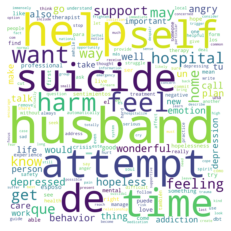

In [96]:
wordcloud = WordCloud(width=2000, height=2000, background_color = 'white',min_font_size=20)
wordcloud.generate_from_frequencies(frequencies=words_topic[18])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [97]:
wordcloud.to_file('../Images/18-selfharm.png')

In [ ]:
'SPIRITUALITY' = 0
'COUNSELING' = 1

'WORKPLACE' = 2
'FAMILY' = 3
'RELATIONSHIPS' = 4
'SLEEP' = 5
'BEHAVIOR' = 6
'SEXUALITY' = 7
'SELF_ESTEEM' = 8
'GRIEF' = 9
'TRAUMA' = 10

'STRESS' = 11
'EATING_DISORDERS' = 12
'ADDICTION' = 13
'DEPRESSION' = 14
'LGBTQ' = 15

'DOMESTIC_VIOLENCE' = 16
'SELF_HARM' = 17